# 🥇 Main Experiments 🥈🥉

🕶️ **To evaluate the frequency estimation performance, we compare our UCL-sketch with eight baselines on four datasets.**

- **Baselines** : `CM-sketch`, `C-sketch`, `Elastic Sketch`, `UnivMon`, `Nitrosketch`, `Learned CM-sketch`, and `Learned C-sketch`.

- **Datasets** : *CAIDA*, *Retail*, *Kosarak*, and *Zipfian*

- **Metrics** : *Average Relative Error (ARE)*, *Weighted Mean Relative Difference (WMRD)*, and *Entropy Relative Error*

## 🚄  Step 1 - Import necessary packets

In [1]:
import torch
import random
import argparse
import numpy as np

from tqdm.auto import tqdm
from load_data import readTraces
from Sketching.unimon import UnivMon
from Sketching.cs_sketch import Csketch
from Sketching.cm_sketch import CMsketch
from Utils.training import learningSolver
from UCL_sketch.ucl_sketch import UCLSketch
from Sketching.nitro_sketch import NitroSketch
from Sketching.elastic_sketch import ElasticSketch

## 🔨 Step 2 - Configure your parameters

In [2]:
parser = argparse.ArgumentParser(description='Main Experiment')

parser.add_argument('--data', type=str, default='network', help='data',
                     choices=['retail', 'kosarak', 'network', 'synthetic'])
parser.add_argument('--root_path', type=str, default='./data/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='test-8s.dat', help='data file',
                    choices=['retail.dat', 'kosarak.dat', 'test-8s.dat', ''])
parser.add_argument('--seed', type=int, default=12345, help='random seed')

parser.add_argument('--slot_num', type=int, default=1200, help='Number of slots in the hash table')
parser.add_argument('--bf_width', type=int, default=390000, help='Length of the Bloom Filter')
parser.add_argument('--bf_hash', type=int, default=8, help='Number of used hash functions of the Bloom Filter')
parser.add_argument('--key_size', type=int, default=13, help='KEY_T_SIZE')
parser.add_argument('--hash_num', type=int, default=4, help='Number of used hash functions of the Sketch')
parser.add_argument('--bucket_dim', type=int, default=512, help='Number of dimensions of each hash vector in the Sketch')
parser.add_argument('--d_model', type=int, default=128, help='dimension of hidden states (d_model)')
parser.add_argument('--break_number', type=int, default=1000000, help='number of stream data')
parser.add_argument('--e_layers', type=int, default=0, help='Number of middle layers')
parser.add_argument('--dropout', type=float, default=0., help='dropout')
parser.add_argument('--d_share', type=int, default=1024, help='length of the logical bucket')
parser.add_argument('--checkpoints', type=str, default='./checkpoints', help='location to store model checkpoints')

parser.add_argument('--num_workers', type=int, default=0, help='data loader num workers')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--train_epochs', type=int, default=300, help='train epochs')
parser.add_argument('--patience', type=int, default=30, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='optimizer initial learning rate')
parser.add_argument('--lradj', type=str, default='type1',help='adjust learning rate')

parser.add_argument('--save_pred', action='store_true', help='whether to save the estimated frequency', default=False)
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3',help='device ids of multile gpus')

parser.add_argument('--interval', type=int, default=1000, help='sampling inserval')
parser.add_argument('--num_samples', type=int, default=128, help='maintained samples (sliding window)')
parser.add_argument('--ablation', type=int, default=0, help='ablational type')

args = parser.parse_known_args()[0]

In [3]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    print(args.gpu)

print(f"Global seed set to {args.seed}")
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

Global seed set to 12345


In [4]:
ucl_sketch = UCLSketch(args.slot_num, args.bucket_dim, args.hash_num, args.bf_width, args.bf_hash, args.key_size)
_ = ucl_sketch.get_memory_usage()

----- Memory Usage -----
Hash Table Size(Byte): 25221 (24.63 KB)
Bloom Filter Size(Byte): 48751 (47.61 KB)
CM Sketch Size(Byte): 8336 (8.14 KB)
Total Memory(MB): 80.38 KB
------------------------


In [5]:
bucket_dim = 1024
slot_num = 3500

c_sketch = Csketch(bucket_dim*5, 4, args.key_size)
lc_sketch = Csketch(bucket_dim*3, 4, args.key_size)
cm_sketch = CMsketch(bucket_dim*5, 4, args.key_size)
lcm_sketch = CMsketch(bucket_dim*3, 4, args.key_size)
nitro_sketch = NitroSketch(bucket_dim*5, 4, args.key_size)
elastic_sketch = ElasticSketch(slot_num//65, slot_num//100, bucket_dim*3, 4, args.key_size)
univmon = UnivMon(2, bucket_dim*4, 4, args.key_size)

ls = Csketch(bucket_dim*3, 4, args.key_size)

print(f'CM-Sketch size: {(c_sketch.get_memory_usage() / (1024)):.2f} KB')
print(f'C-Sketch size: {(cm_sketch.get_memory_usage() / (1024)):.2f} KB')
print(f'Nitro-Sketch size: {(nitro_sketch.get_memory_usage() / (1024)):.2f} KB')
print(f'Elastic Sketch size: {(elastic_sketch.get_memory_usage() / (1024)):.2f} KB')
print(f'UnivMon size: {(univmon.get_memory_usage() / (1024)):.2f} KB')

CM-Sketch size: 80.42 KB
C-Sketch size: 80.42 KB
Nitro-Sketch size: 80.45 KB
Elastic Sketch size: 79.13 KB
UnivMon size: 96.12 KB


## ⏩ Step 3 - Insert data stream

In [6]:
path = args.root_path + args.data_path
size, traces = readTraces(path, args.data, args.key_size)

if size > args.break_number:
    traces = traces[:args.break_number]
    size = args.break_number

Reading in packets data...
Successfully read in 3670738 items.


In [7]:
packetCnt = 0
ground_truth = {}
sample_initial = size - (args.interval + 12) * args.num_samples

args.bucket_dim = ucl_sketch.cm.width
samples = np.empty([0, args.hash_num, args.bucket_dim])

with tqdm(initial=0, total=size, desc='Inserting packets into the sketch') as pbar:
    for idx, trace in enumerate(traces):
        if trace in ground_truth:
            ground_truth[trace] += 1
        else:
            ground_truth[trace] = 1
            
        ucl_sketch.insert(trace)
        packetCnt += 1
        pbar.update(1)
        
        if idx > sample_initial and idx % args.interval == 0:
            sample = ucl_sketch.get_current_state(return_A=False)
            samples = np.row_stack([samples, sample])

GT_sorted = sorted(ground_truth, key=lambda x: ground_truth[x])
topk_keys = GT_sorted[- args.slot_num:]
GT_ideal = GT_sorted[:- args.slot_num]

for key in GT_ideal:
    value = ground_truth[key]
    lc_sketch.insert(key, value)
    lcm_sketch.insert(key, value)
    c_sketch.insert(key, value)
    cm_sketch.insert(key, value)
    nitro_sketch.insert(key, value)
    elastic_sketch.insert(key, value)
    univmon.insert(key, value)

for key in topk_keys:
    value = ground_truth[key]
    c_sketch.insert(key, value)
    cm_sketch.insert(key, value)
    nitro_sketch.insert(key, value)
    elastic_sketch.insert(key, value)
    univmon.insert(key, value)

print(f'Insert {packetCnt} items with {len(ground_truth)} distinct keys. Meanwhile, {samples.shape[0]} points is sampled.')

Inserting packets into the sketch:   0%|          | 0/1000000 [00:00<?, ?it/s]

Insert 1000000 items with 93703 distinct keys. Meanwhile, 129 points is sampled


## ⛺ Step 4 - Train the learning-based solver

In [8]:
A, index = ucl_sketch.get_current_state(return_A=True)
solver = learningSolver(args, A.shape[1])
solver.train(samples, A, index)

Use GPU: cuda:0
Epoch: 1 cost time: 1.1761531829833984
Epoch: 1, Steps: 4 | Train Loss: 6352.6199951
Validation loss decreased (inf --> 6352.619995).  Saving model ...
Epoch: 2 cost time: 0.05572772026062012
Epoch: 2, Steps: 4 | Train Loss: 4503.2796631
Validation loss decreased (6352.619995 --> 4503.279663).  Saving model ...
Epoch: 3 cost time: 0.05354952812194824
Epoch: 3, Steps: 4 | Train Loss: 2350.4320068
Validation loss decreased (4503.279663 --> 2350.432007).  Saving model ...
Epoch: 4 cost time: 0.062497615814208984
Epoch: 4, Steps: 4 | Train Loss: 788.5931473
Validation loss decreased (2350.432007 --> 788.593147).  Saving model ...
Epoch: 5 cost time: 0.06097841262817383
Epoch: 5, Steps: 4 | Train Loss: 170.4180698
Validation loss decreased (788.593147 --> 170.418070).  Saving model ...
Epoch: 6 cost time: 0.06200265884399414
Epoch: 6, Steps: 4 | Train Loss: 30.8279457
Validation loss decreased (170.418070 --> 30.827946).  Saving model ...
Epoch: 7 cost time: 0.06250977516174

## 🤔 Step 5 - Per-key frequency query

In [9]:
results = {'GT': [], 'UCL': [], 'ES': [], 'UM': [], 'CM': [],
           'CS': [], 'NS': [], 'LCM': [], 'LCS': []}

print('Querying for all keys ...')

for key, value in ground_truth.items():
    c_ans = c_sketch.query(key)
    cm_ans = cm_sketch.query(key)
    nitro_ans = nitro_sketch.query(key)
    ela_ans = elastic_sketch.query(key)
    uni_ans = univmon.query(key)

    if key in topk_keys:
        lc_ans = value
        lcm_ans = value
    else:
        lc_ans = lc_sketch.query(key)
        lcm_ans = lcm_sketch.query(key)

    if ucl_sketch.cmResult == {}:
        test_sample = ucl_sketch.get_current_state(return_A=False)
        x = solver.test(test_sample)
        x = np.ceil(x.squeeze()).astype(np.int32)

    ucl_ans = ucl_sketch.query(key, x)

    results['GT'].append(value)
    results['UCL'].append(ucl_ans)
    results['ES'].append(ela_ans)
    results['UM'].append(uni_ans)
    results['CM'].append(cm_ans)
    results['CS'].append(c_ans)
    results['NS'].append(nitro_ans)
    results['LCM'].append(lcm_ans)
    results['LCS'].append(lc_ans)

Querying for all keys ...


## 🏆 Step 6 - Caculate related metrics

In [10]:
from Utils.mertrics import *

GT = results['GT']

AAE_R = []
ARE_R = []
WMRD_R = []
EAE_R = []

print('Performace of UCL-sketch:')
ET = results['UCL']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of CM-sketch:')
ET = results['CM']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of C-sketch:')
ET = results['CS']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of Ideally Learned CM-sketch:')
ET = results['LCM']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of Ideally Learned C-sketch:')
ET = results['LCS']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of Elastic Sketch:')
ET = results['ES']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of UnivMon:')
ET = results['UM']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

print('Performace of NitroSketch:')
ET = results['NS']
AAE = average_absolute_error(GT, ET)
ARE = average_relative_error(GT, ET)
WMRD = weighted_mean_relative_difference(GT, ET)
EAE = entropy_absolute_error(GT, ET)
print(f'—— AAE: {AAE:.4f}, ARE: {ARE:.4f}, WMRD: {WMRD:.4f}, and Entropy Absolute Error: {EAE:.4f}')
AWE = average_weighted_error(GT, ET)

AAE_R.append(int(AAE*100)/100)
ARE_R.append(int(ARE*100)/100)
WMRD_R.append(int(WMRD*100)/100)
EAE_R.append(int(EAE*100)/100)

Performace of UCL-sketch:
—— AAE: 10.3648, ARE: 4.1250, WMRD: 0.2814, and Entropy Absolute Error: 12.1944
Performace of CM-sketch:
—— AAE: 53.2953, ARE: 33.9676, WMRD: 1.8384, and Entropy Absolute Error: 379.7376
Performace of C-sketch:
—— AAE: 47.0902, ARE: 30.3507, WMRD: 1.6648, and Entropy Absolute Error: 447.8732
Performace of Ideally Learned CM-sketch:
—— AAE: 90.2877, ARE: 58.3427, WMRD: 1.9237, and Entropy Absolute Error: 632.1375
Performace of Ideally Learned C-sketch:
—— AAE: 72.8543, ARE: 47.2258, WMRD: 1.8458, and Entropy Absolute Error: 599.1181
Performace of Elastic Sketch:
—— AAE: 102.9287, ARE: 65.6268, WMRD: 1.9257, and Entropy Absolute Error: 792.9259
Performace of UnivMon:
—— AAE: 81.2230, ARE: 52.0394, WMRD: 1.7953, and Entropy Absolute Error: 788.1667
Performace of NitroSketch:
—— AAE: 48.4198, ARE: 31.0829, WMRD: 1.7350, and Entropy Absolute Error: 159.9182


## 📶 Step 7 - Plot the results

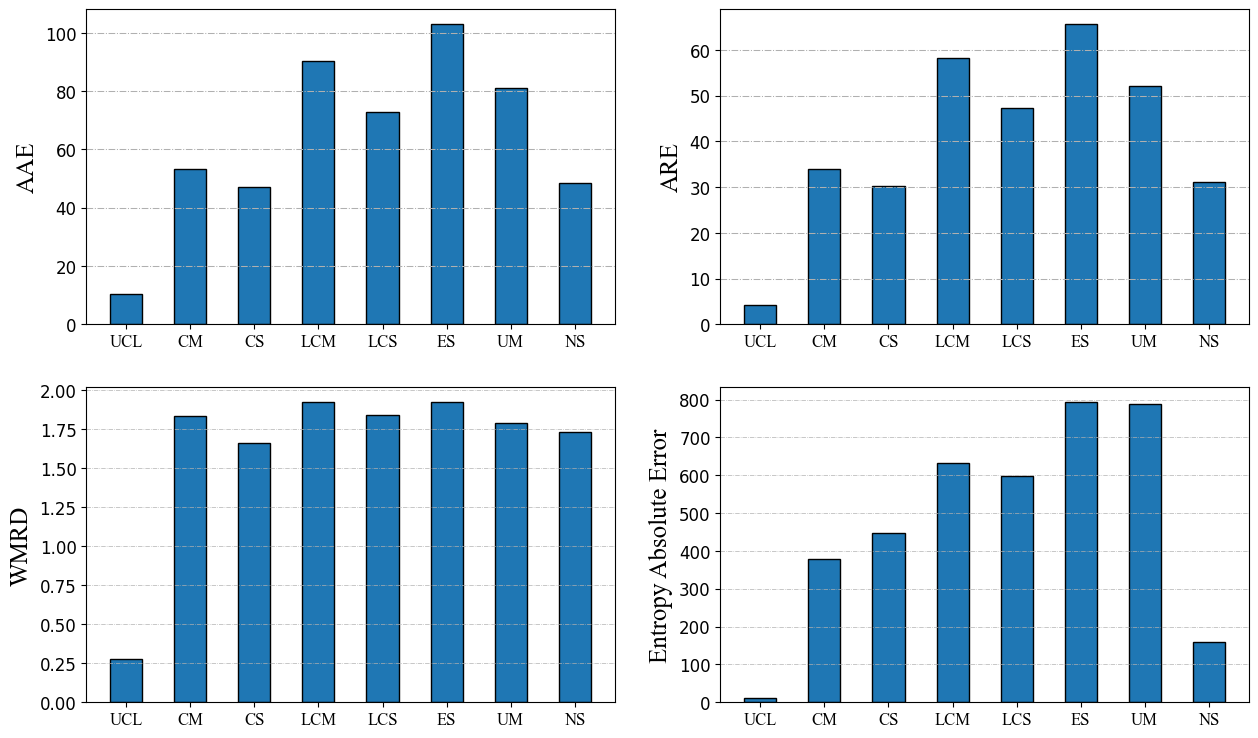

In [11]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

width = 0.5
x_n = ['UCL', 'CM', 'CS', 'LCM', 'LCS', 'ES', 'UM', 'NS']
x = np.arange(len(x_n))

ax1.bar(x, AAE_R, width=width, edgecolor='k')
ax1.set_xticks(x, labels=x_n, fontproperties='Times New Roman', fontsize=12)
ax1.set_ylabel('AAE', fontdict={'family': 'Times New Roman', 'size': 18})
ax1.tick_params('both', labelsize=12)
ax1.grid(axis='y', linestyle='-.', lw=0.75)

ax2.bar(x, ARE_R, width=width, edgecolor='k')
ax2.set_xticks(x, labels=x_n, fontproperties='Times New Roman', fontsize=12)
ax2.set_ylabel('ARE', fontdict={'family': 'Times New Roman', 'size': 18})
ax2.tick_params('both', labelsize=12)
ax2.grid(axis='y', linestyle='-.', lw=0.75)

ax3.bar(x, WMRD_R, width=width, edgecolor='k')
ax3.set_xticks(x, labels=x_n, fontproperties='Times New Roman', fontsize=12)
ax3.set_ylabel('WMRD', fontdict={'family': 'Times New Roman', 'size': 18})
ax3.tick_params('both', labelsize=12)
ax3.grid(axis='y', linestyle='-.', lw=0.5)

ax4.bar(x, EAE_R, width=width, edgecolor='k')
ax4.set_xticks(x, labels=x_n, fontproperties='Times New Roman', fontsize=12)
ax4.set_ylabel('Entropy Absolute Error', fontdict={'family': 'Times New Roman', 'size': 18})
ax4.tick_params('both', labelsize=12)
ax4.grid(axis='y', linestyle='-.', lw=0.5)

plt.show()